# NLP Assignment 2  RNN/CNN-based Natural Language Inference

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import matplotlib.pyplot as plt

In [2]:
words_to_load = 50000
PAD_IDX = 0
UNK_IDX = 1
import numpy as np
# reserve the 1st 2nd token for padding and <UNK> respectively
with open('wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+2, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    ordered_words_ft.extend(['<pad>', '<unk>'])
    loaded_embeddings_ft[0,:] = np.zeros(300)
    loaded_embeddings_ft[1,:] = np.random.normal(size = 300)
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+2, :] = np.asarray(s[1:])
        words_ft[s[0]] = i+2
        idx2words_ft[i+2] = s[0]
        ordered_words_ft.append(s[0])
    words_ft['<pad>'] = 0
    words_ft['<unk>'] = 1
    idx2words_ft[0] = '<pad>'
    idx2words_ft[1] = '<unk>'

In [3]:
# convert tokens in df to word vectors 
label_dic = {'neutral':0, 'contradiction':1, 'entailment':2}
def word_to_vec(word_list):
    return [loaded_embeddings_ft[words_ft[x]] if x in ordered_words_ft else loaded_embeddings_ft[1] for x in word_list]
def word_to_id(word_list):
    return [words_ft[x] if x in ordered_words_ft else UNK_IDX for x in word_list]
def convert_data(df):
    df['token1_x'] = df['token1'].apply(lambda x: word_to_vec(x))
    df['token2_x'] = df['token2'].apply(lambda x: word_to_vec(x))
    df['y'] = df['label'].apply(lambda x: label_dic[x])
    return df

In [5]:
train_data_df = pd.DataFrame.from_csv('hw2_data/snli_train.tsv', sep='\t', index_col=None)
test_data_df = pd.DataFrame.from_csv('hw2_data/snli_val.tsv', sep='\t', index_col=None)
train_data_df['token1'] = [x.split() for x in train_data_df.sentence1]
train_data_df['token2'] = [x.split() for x in train_data_df.sentence2]
test_data_df['token1'] = [x.split() for x in test_data_df.sentence1]
test_data_df['token2'] = [x.split() for x in test_data_df.sentence2]

In [5]:
train_data_df2 = convert_data(train_data_df)
test_data_df2 = convert_data(test_data_df)

In [7]:
def list2id(sent_list):
    return [word_to_id(x) for x in sent_list]

In [95]:
train_list_pre = train_data_df['token1'].values.tolist()
train_list_hypo = train_data_df['token2'].values.tolist()
test_list_pre = test_data_df['token1'].values.tolist()
test_list_hypo = test_data_df['token2'].values.tolist()
train_id_pre = list2id(train_list_pre)
train_id_hypo = list2id(train_list_hypo)
test_id_pre = list2id(test_list_pre)
test_id_hypo = list2id(test_list_hypo)
#save list to pickle
pkl.dump(train_id_pre, open("train_id_pre.p", "wb"))
pkl.dump(train_id_hypo, open("train_id_hypo.p", "wb"))
pkl.dump(test_id_pre, open("test_id_pre.p", "wb"))
pkl.dump(test_id_hypo, open("test_id_hypo.p", "wb"))
pkl.dump(list(train_data_df2.y.values), open("train_y.p", "wb"))
pkl.dump(list(test_data_df2.y.values), open("test_y.p", "wb"))

In [4]:
def read_tokenizing_data():
    train_id_pre = pkl.load(open("train_id_pre.p", 'rb'))
    train_id_hypo = pkl.load(open("train_id_hypo.p", 'rb'))
    test_id_pre = pkl.load(open("test_id_pre.p", 'rb'))
    test_id_hypo = pkl.load(open("test_id_hypo.p", 'rb'))
    train_y = pkl.load(open("train_y.p", 'rb'))
    test_y = pkl.load(open("test_y.p", 'rb'))
#     idx2words_ft = pkl.load(open("idx2words_ft.p", 'rb'))
#     loaded_embeddings_ft= pkl.load(open("loaded_embeddings_ft.p", 'rb'))
#     ordered_words_ft= pkl.load(open("ordered_words_ft.p", 'rb'))
#     words_ft= pkl.load(open("words_ft.p", 'rb'))
    return train_id_pre, train_id_hypo, test_id_pre, test_id_hypo, train_y, test_y

In [5]:
train_id_pre, train_id_hypo, test_id_pre, test_id_hypo, train_y, test_y = read_tokenizing_data()

In [6]:
train_tuple = list(zip(train_id_pre, train_id_hypo, train_y))
test_tuple = list(zip(test_id_pre, test_id_hypo, test_y))

In [7]:
# top 1% length
MAX_LENGTH = sorted(len(x) for x in train_id_pre + train_id_hypo)[-int(len(train_id_pre + train_id_hypo)*0.01)]
BATCH_SIZE = 32

In [8]:
# build DataLoader
class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_pre_list, self.data_hypo_list, self.target_list = zip(*data_tuple)
        assert (len(self.data_pre_list) == len(self.target_list))
        assert (len(self.data_hypo_list) == len(self.target_list))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        char_idx1 = self.data_pre_list[key][:MAX_LENGTH]
        char_idx2 = self.data_hypo_list[key][:MAX_LENGTH]
        label = self.target_list[key]
        return [char_idx1, char_idx2, len(char_idx1), len(char_idx2), label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list_pre = []
    data_list_hypo = []
    label_list = []
    length_list_pre = []
    length_list_hypo = []

    for datum in batch:
        label_list.append(datum[4])
        length_list_pre.append(datum[2])
        length_list_hypo.append(datum[3])
    # padding
    for datum in batch:
        padded_vec_pre = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        padded_vec_hypo = np.pad(np.array(datum[1]),
                                pad_width = ((0, MAX_LENGTH-datum[3])), 
                                mode = "constant", constant_values= 0)
        data_list_pre.append(padded_vec_pre)
        data_list_hypo.append(padded_vec_hypo)
#     ind_dec_order_pre = np.argsort(length_list_pre)[::-1]
#     ind_dec_order_hypo = np.argsort(length_list_hypo)[::-1]
#     data_list_pre = np.array(data_list_pre)[ind_dec_order_pre]
#     data_list_hypo = np.array(data_list_pre)[ind_dec_order_hypo]
#     length_list_pre = np.array(length_list_pre)[ind_dec_order_pre]
#     length_list_hypo = np.array(length_list_hypo)[ind_dec_order_hypo]
#     label_list = np.array(label_list)[ind_dec_order]
    if torch.cuda.is_available and torch.has_cudnn:
        return [torch.from_numpy(np.array(data_list_pre)).cuda(), torch.from_numpy(np.array(data_list_hypo)).cuda(),
            torch.LongTensor(length_list_pre).cuda(), torch.LongTensor(length_list_hypo).cuda(), torch.LongTensor(label_list).cuda()]
    else:
        return [torch.from_numpy(np.array(data_list_pre)), torch.from_numpy(np.array(data_list_hypo)),
            torch.LongTensor(length_list_pre), torch.LongTensor(length_list_hypo), torch.LongTensor(label_list)]



In [9]:
train_dataset = SNLIDataset(train_tuple)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = SNLIDataset(test_tuple)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

## CNN

In [38]:
#CNN
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, kernel_size, num_classes, dropout_layer = False):

        super(CNN, self).__init__()
        self.dropout_layer = dropout_layer
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(loaded_embeddings_ft).float(), freeze=True)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size, padding=0)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=0)
#         self.pool = nn.MaxPool1d(2, stride=2)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()

    def forward(self, x1, x2, length1, length2):
        batch_size, seq_len1 = x1.size()
        _, seq_len2 = x2.size()

        embed1 = self.embedding(x1)
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1, 2)
        hidden1 = self.relu(hidden1)
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = self.relu(hidden1)
#         hidden1 = self.pool(hidden1)
#         hidden1 = torch.sum(hidden1, dim=1)
#         hidden1 = torch.max(hidden1, dim=1)[0]
        
        embed2 = self.embedding(x2)
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = self.relu(hidden2)
        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = self.relu(hidden2)
#         hidden2 = self.pool(hidden2)
#         hidden2 = torch.sum(hidden2, dim=1)
#         hidden2 = torch.max(hidden2, dim=1)[0]
    
        hidden = torch.cat((hidden1, hidden2), dim = 1)
        hidden = torch.max(hidden, dim=1)[0]
        if self.dropout_layer:
            hidden = self.dropout(hidden)
        hidden = self.linear1(hidden)
        hidden = F.relu(hidden)
        logits = self.linear2(hidden)
        
        return logits

In [39]:
def test_model_cnn(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, data2, length1, length2, labels in loader:
        data1_batch, data2_batch, length1_batch, length2_batch, label_batch = data1, data2, length1, length2, labels
        outputs = F.softmax(model(data1_batch,data2_batch, length1_batch, length2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [57]:
if torch.cuda.is_available and torch.has_cudnn:
    model = CNN(emb_size=300, hidden_size=200, kernel_size=3, num_classes=3).cuda()
else:
    model = CNN(emb_size=300, hidden_size=200, kernel_size=3, num_classes=3)
learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

cnn_train_loss_list = []
cnn_val_acc_list = []
for epoch in range(num_epochs):
    for i, (data1, data2, length1, length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1, data2, length1, length2)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        cnn_train_loss_list.append(loss.item())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model_cnn(val_loader, model)
            cnn_val_acc_list.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

Epoch: [1/10], Step: [101/3125], Validation Acc: 33.1
Epoch: [1/10], Step: [201/3125], Validation Acc: 34.8
Epoch: [1/10], Step: [301/3125], Validation Acc: 45.1
Epoch: [1/10], Step: [401/3125], Validation Acc: 48.6
Epoch: [1/10], Step: [501/3125], Validation Acc: 50.5
Epoch: [1/10], Step: [601/3125], Validation Acc: 53.1
Epoch: [1/10], Step: [701/3125], Validation Acc: 52.0
Epoch: [1/10], Step: [801/3125], Validation Acc: 52.8
Epoch: [1/10], Step: [901/3125], Validation Acc: 51.2
Epoch: [1/10], Step: [1001/3125], Validation Acc: 53.2
Epoch: [1/10], Step: [1101/3125], Validation Acc: 53.3
Epoch: [1/10], Step: [1201/3125], Validation Acc: 53.9
Epoch: [1/10], Step: [1301/3125], Validation Acc: 54.0
Epoch: [1/10], Step: [1401/3125], Validation Acc: 53.8
Epoch: [1/10], Step: [1501/3125], Validation Acc: 54.8
Epoch: [1/10], Step: [1601/3125], Validation Acc: 53.8
Epoch: [1/10], Step: [1701/3125], Validation Acc: 55.8
Epoch: [1/10], Step: [1801/3125], Validation Acc: 56.2
Epoch: [1/10], Step

Epoch: [5/10], Step: [2701/3125], Validation Acc: 62.3
Epoch: [5/10], Step: [2801/3125], Validation Acc: 63.3
Epoch: [5/10], Step: [2901/3125], Validation Acc: 61.7
Epoch: [5/10], Step: [3001/3125], Validation Acc: 64.7
Epoch: [5/10], Step: [3101/3125], Validation Acc: 63.9
Epoch: [6/10], Step: [101/3125], Validation Acc: 63.3
Epoch: [6/10], Step: [201/3125], Validation Acc: 63.5
Epoch: [6/10], Step: [301/3125], Validation Acc: 61.8
Epoch: [6/10], Step: [401/3125], Validation Acc: 64.0
Epoch: [6/10], Step: [501/3125], Validation Acc: 60.6
Epoch: [6/10], Step: [601/3125], Validation Acc: 61.7
Epoch: [6/10], Step: [701/3125], Validation Acc: 63.6
Epoch: [6/10], Step: [801/3125], Validation Acc: 63.5
Epoch: [6/10], Step: [901/3125], Validation Acc: 62.8
Epoch: [6/10], Step: [1001/3125], Validation Acc: 64.5
Epoch: [6/10], Step: [1101/3125], Validation Acc: 63.3
Epoch: [6/10], Step: [1201/3125], Validation Acc: 63.9
Epoch: [6/10], Step: [1301/3125], Validation Acc: 62.7
Epoch: [6/10], Step

Epoch: [10/10], Step: [2201/3125], Validation Acc: 61.6
Epoch: [10/10], Step: [2301/3125], Validation Acc: 62.2
Epoch: [10/10], Step: [2401/3125], Validation Acc: 61.0
Epoch: [10/10], Step: [2501/3125], Validation Acc: 60.5
Epoch: [10/10], Step: [2601/3125], Validation Acc: 60.2
Epoch: [10/10], Step: [2701/3125], Validation Acc: 60.3
Epoch: [10/10], Step: [2801/3125], Validation Acc: 61.9
Epoch: [10/10], Step: [2901/3125], Validation Acc: 62.0
Epoch: [10/10], Step: [3001/3125], Validation Acc: 60.9
Epoch: [10/10], Step: [3101/3125], Validation Acc: 60.5


### Visualization

In [59]:
def plot_nn(train_loss, val_acc, title_name = 'CNN'):
    plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(121)
    ax1.plot(train_loss)
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('training loss')
    ax2 = plt.subplot(122)
    ax2.plot(val_acc)
    ax2.set_xlabel('iterations')
    ax2.set_ylabel('validation accuracy')
    plt.suptitle(title_name)
    plt.show()

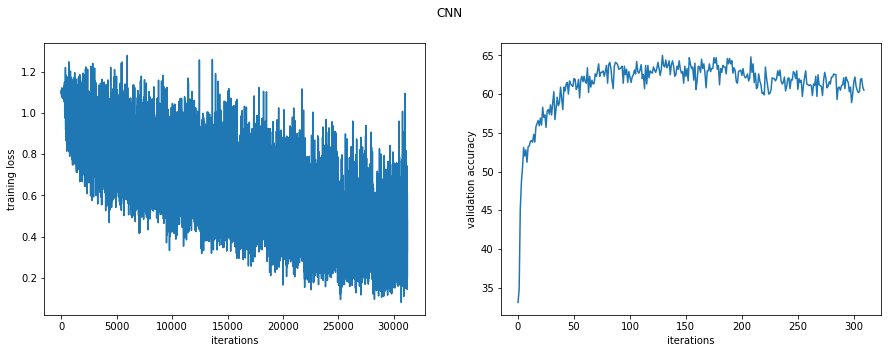

In [60]:
plot_nn(cnn_train_loss_list, cnn_val_acc_list)

### Tuning

In [44]:
def tuning_cnn(hidden_s, kernel_s, dropout_l = False):
    if torch.cuda.is_available and torch.has_cudnn:
        model = CNN(emb_size=300, hidden_size = hidden_s, kernel_size=kernel_s, num_classes=3, dropout_layer = dropout_l).cuda()
    else:
        model = CNN(emb_size=300, hidden_size = hidden_s, kernel_size=kernel_s, num_classes=3, dropout_layer = dropout_l)

    learning_rate = 3e-4
    num_epochs = 5 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (data1, data2, length1, length2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1, data2, length1, length2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
    
    val_acc = test_model_cnn(val_loader, model)                
    return (loss.item(), val_acc)

In [45]:
def plot_tune(train_list, val_list, y_list, parameter_name = 'hidden dimension', title_name = 'CNN'):
    plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(121)
    ax1.plot(y_list, train_list)
    ax1.set_xlabel(parameter_name)
    ax1.set_ylabel('training loss')
    ax2 = plt.subplot(122)
    ax2.plot(y_list, val_list)
    ax2.set_xlabel(parameter_name)
    ax2.set_ylabel('validation accuracy')
    plt.suptitle(title_name + ' Tuning Parameters')
    plt.show()

In [63]:
# hidden-dimension
cnn_train_hidden = []
cnn_val_hidden = []
cnn_hidden = [100, 200, 300, 400]
for num in cnn_hidden:
    loss, val = tuning_cnn(hidden_s=num, kernel_s=3)
    cnn_train_hidden.append(loss)
    cnn_val_hidden.append(val)

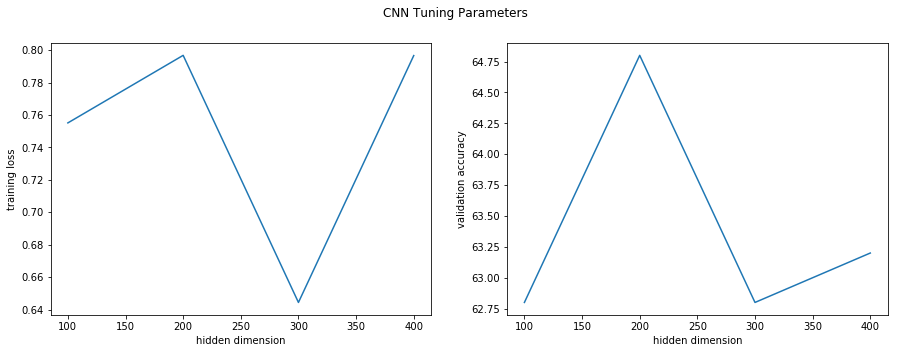

In [64]:
plot_tune(cnn_train_hidden, cnn_val_hidden, cnn_hidden)

In [46]:
# kernel size
cnn_train_kernel = []
cnn_val_kernel = []
cnn_kernel = [2, 3, 4, 5]
for num in cnn_kernel:
    loss, val = tuning_cnn(hidden_s=200, kernel_s=num)
    cnn_train_kernel.append(loss)
    cnn_val_kernel.append(val)

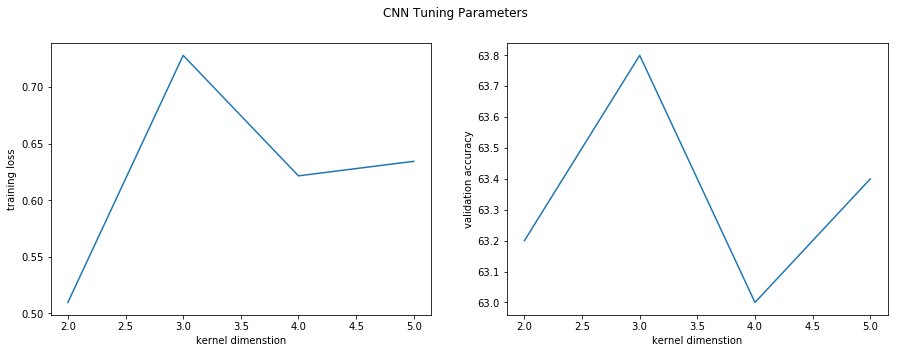

In [47]:
plot_tune(cnn_train_kernel, cnn_val_kernel, cnn_kernel, parameter_name = 'kernel dimenstion')

In [49]:
# add dropout
print('No Dropout:')
print('Train Loss: {} \nValidation Accuracy:{}'.format(cnn_train_kernel[np.argmax(cnn_val_kernel)], max(cnn_val_kernel)))
loss, val = tuning_cnn(hidden_s=300, kernel_s=3, dropout_l=True)
print('After Adding Dropout:')
print('Train Loss: {} \nValidation Accuracy:{}'.format(loss, val))

No Dropout:
Train Loss: 0.7282431125640869 
Validation Accuracy:63.8
After Adding Dropout:
Train Loss: 0.9431334137916565 
Validation Accuracy:65.2


## RNN

In [71]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, linear_size, include_regular, ele_mul = False):
        super(RNN, self).__init__()
        self.include_reg, self.ele_mul = include_regular, ele_mul
        if self.ele_mul:
            linear_hidden_factor = 1
        else:
            linear_hidden_factor = 2
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(loaded_embeddings_ft).float(), freeze=True)
        self.gru = nn.GRU(emb_size, hidden_size, num_layers = 1, batch_first=False, bidirectional=True)
        self.linear1 = nn.Linear(hidden_size*linear_hidden_factor, linear_size)
        self.linear2 = nn.Linear(linear_size, num_classes)
        self.dropout = nn.Dropout(p = include_regular)
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        if torch.cuda.is_available and torch.has_cudnn:
            hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size).cuda()
        else:
            hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)
        return hidden
    
    def forward(self, x1, x2, length1, length2):
        # reset hidden state

        batch_size, seq_len1 = x1.size()
        _, seq_len2 = x2.size()

        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)
        _, idx_sort1 = torch.sort(length1, dim=0, descending=True)
        _, idx_sort2 = torch.sort(length2, dim=0, descending=True)
        
        #unsort 
        _, idx_unsort1 = torch.sort(idx_sort1, dim=0)
        _, idx_unsort2 = torch.sort(idx_sort2, dim=0)

        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        
        # sort embedding
        embed1 = embed1.index_select(0, idx_sort1)
        embed2 = embed2.index_select(0, idx_sort2)
        sorted_len1 = length1[idx_sort1]
        sorted_len2 = length2[idx_sort2]
        
        # pack padded sequence
        if torch.cuda.is_available and torch.has_cudnn:
            embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, sorted_len1.cpu().numpy(), batch_first=True)
            embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, sorted_len2.cpu().numpy(), batch_first=True)
        else:
            embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, sorted_len1.numpy(), batch_first=True)
            embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, sorted_len2.numpy(), batch_first=True)
        # fprop though gru
        rnn_out1, self.hidden1 = self.gru(embed1, self.hidden1)
        rnn_out2, self.hidden2 = self.gru(embed2, self.hidden2)
        # last hidden activations of RNN across time
        rnn_out1 = self.hidden1.cpu()[-1,:,:]
        rnn_out2 = self.hidden2.cpu()[-1,:,:]
#         rnn_out1 = torch.sum(self.hidden1, dim=0)
#         rnn_out2 = torch.sum(self.hidden2, dim=0)
        
        # unsort
        if torch.cuda.is_available and torch.has_cudnn:
            output1 = rnn_out1.cuda().index_select(0, idx_unsort1)
            output2 = rnn_out2.cuda().index_select(0, idx_unsort2)
        else:
            output1 = rnn_out1.index_select(0, idx_unsort1)
            output2 = rnn_out2.index_select(0, idx_unsort2)
        #concat or element wise
        if self.ele_mul:
            hidden3 = torch.mul(output1, output2)
        else:
            hidden3 = torch.cat((output1, output2), dim = 1)
        hidden3 = self.dropout(hidden3)
        hidden3 = self.linear1(hidden3)
        hidden3 = F.relu(hidden3)
        logits = self.linear2(hidden3)

        return logits

In [68]:
def test_model_rnn(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, data2, length1, length2, labels in loader:
        data1_batch, data2_batch, length1_batch, length2_batch, label_batch = data1, data2, length1, length2, labels
        outputs = F.softmax(model(data1_batch,data2_batch, length1_batch, length2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [16]:
if torch.cuda.is_available and torch.has_cudnn:
    model = RNN(emb_size=300, hidden_size=200, num_layers=1, num_classes=3, include_regular=0,  linear_size=200).cuda()
else:
    model = RNN(emb_size=300, hidden_size=200, num_layers=1, num_classes=3, include_regular=0, linear_size=200)

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

rnn_train_loss_list = []
rnn_val_acc_list = []
for epoch in range(num_epochs):
    for i, (data1, data2, length1, length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1, data2, length1, length2)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        rnn_train_loss_list.append(loss.item())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model_rnn(val_loader, model)
            rnn_val_acc_list.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

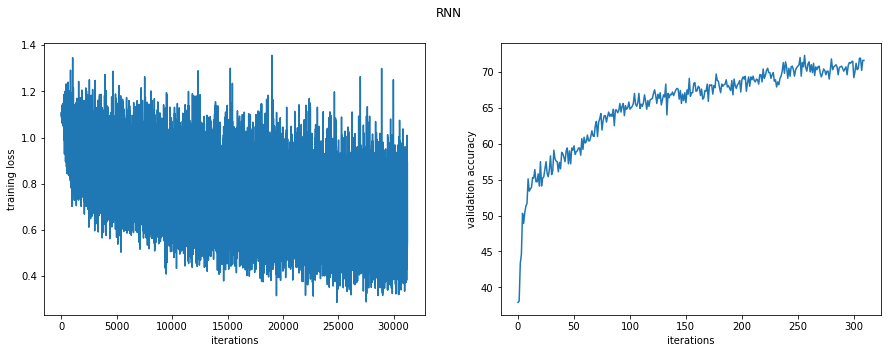

In [44]:
plot_nn(rnn_train_loss_list, rnn_val_acc_list, title_name='RNN')

### Tuning

In [69]:
def tuning_rnn(hidden_s, dropout_l = 0, lr = 3e-4, matrix_mul = False):
    if torch.cuda.is_available and torch.has_cudnn:
        model = RNN(emb_size=300, hidden_size=hidden_s, num_layers=1, num_classes=3, linear_size=200, include_regular = dropout_l, ele_mul = matrix_mul).cuda()
    else:
        model = RNN(emb_size=300, hidden_size=hidden_s, num_layers=1, num_classes=3, linear_size=200, include_regular = dropout_l, ele_mul = matrix_mul)

    learning_rate = lr
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (data1, data2, length1, length2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1, data2, length1, length2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
    val_acc = test_model_rnn(val_loader, model)                
    return (loss.item(), val_acc)

In [72]:
# hidden-dimension
rnn_train_hidden = []
rnn_val_hidden = []
rnn_hidden = [200, 300, 400]
for num in rnn_hidden:
    loss, val = tuning_rnn(hidden_s=num)
    rnn_train_hidden.append(loss)
    rnn_val_hidden.append(val)

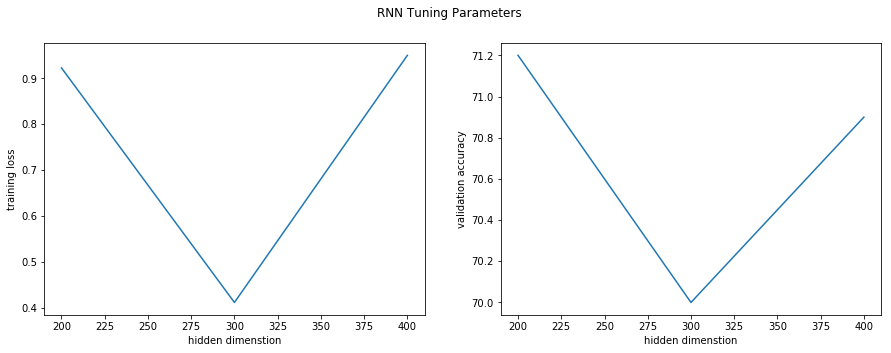

In [73]:
plot_tune(rnn_train_hidden, rnn_val_hidden, rnn_hidden, parameter_name = 'hidden dimenstion', title_name = 'RNN')

In [76]:
# add dropout
print('No Dropout:')
print('Train Loss: {} \nValidation Accuracy:{}'.format(rnn_train_hidden[np.argmax(rnn_val_hidden)], max(rnn_val_hidden)))
dropout_list = [0.1, 0.2, 0.5]
rnn_dropout_loss = []
rnn_dropout_acc = []
for num in dropout_list:
    loss, val = tuning_rnn(hidden_s=200, dropout_l = num)
    rnn_dropout_loss.append(loss)
    rnn_dropout_acc.append(val)
    print('After Adding Dropout:')
    print('Train Loss: {} \nValidation Accuracy:{}'.format(loss, val))

No Dropout:
Train Loss: 0.9226511716842651 
Validation Accuracy:71.2
After Adding Dropout:
Train Loss: 0.6988766193389893 
Validation Accuracy:69.3
After Adding Dropout:
Train Loss: 0.6801987290382385 
Validation Accuracy:68.9
After Adding Dropout:
Train Loss: 0.6451876759529114 
Validation Accuracy:68.6


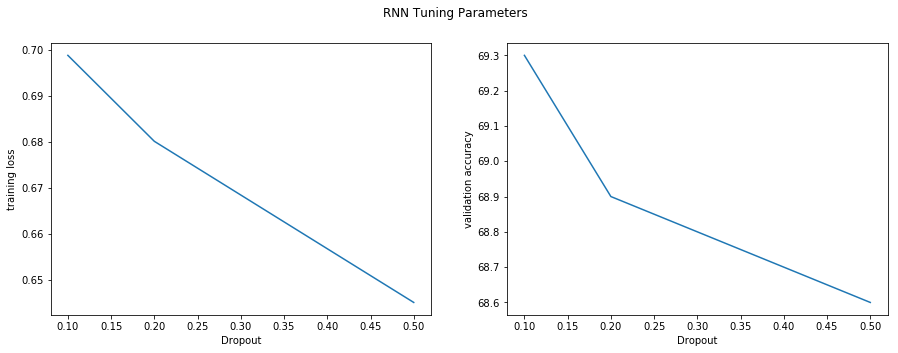

In [77]:
plot_tune(rnn_dropout_loss, rnn_dropout_acc, dropout_list, parameter_name = 'Dropout', title_name = 'RNN')

In [79]:
#lr 
rnn_train_lr = []
rnn_val_lr = []
rnn_lr = [3e-3, 3e-4, 3e-5]
for num in rnn_lr:
    loss, val = tuning_rnn(hidden_s=200, lr=num, dropout_l=0)
    rnn_train_lr.append(loss)
    rnn_val_lr.append(val)

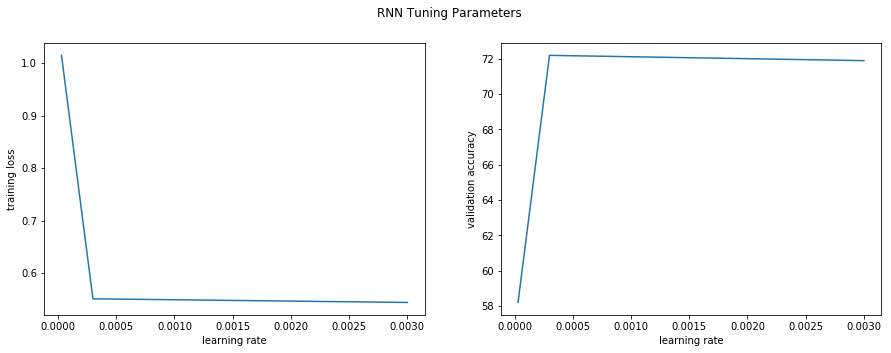

In [80]:
plot_tune(rnn_train_lr, rnn_val_lr, rnn_lr, parameter_name = 'learning rate', title_name = 'RNN')

In [81]:
# element-wise multiplication 
print('concatenate:')
print('Train Loss: {} \nValidation Accuracy:{}'.format(rnn_train_lr[np.argmax(rnn_val_lr)], max(rnn_val_lr)))
loss, val = tuning_rnn(hidden_s=200, lr = 3e-4, matrix_mul = True)
print('element-wise multiplication:')
print('Train Loss: {} \nValidation Accuracy:{}'.format(loss, val))

concatenate:
Train Loss: 0.551131546497345 
Validation Accuracy:72.2
element-wise multiplication:
Train Loss: 0.8770127892494202 
Validation Accuracy:68.6


Best model tuning: RNN (hidden_size = 200, lr = 3e-4,  dropout= false, concat two sentence representations)

### Pick Out Right/Wrong

In [38]:
def test_model_rnn_pick(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    right_list = []
    wrong_list = []
    cnt_right = 0
    cnt_wrong = 0
    model.eval()
    for data1, data2, length1, length2, labels in loader:
        if cnt_right >= 5 and cnt_wrong >=5:
            break
        data1_batch, data2_batch, length1_batch, length2_batch, label_batch = data1, data2, length1, length2, labels
        outputs = F.softmax(model(data1_batch,data2_batch, length1_batch, length2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        equation = predicted.eq(labels.view_as(predicted)).cpu().numpy()
        for idx, cont in enumerate(equation):
            if cont==1:
                right_list.append([data1_batch[idx], data2_batch[idx], label_batch[idx], predicted[idx]])
                cnt_right+=1
            else:
                wrong_list.append([data1_batch[idx], data2_batch[idx], label_batch[idx], predicted[idx]])
                cnt_wrong+=1
    return (right_list, wrong_list)


if torch.cuda.is_available and torch.has_cudnn:
    model = RNN(emb_size=200, hidden_size=400, num_layers=1, num_classes=3, linear_size=200).cuda()
else:
    model = RNN(emb_size=200, hidden_size=400, num_layers=1, num_classes=3, linear_size=200)

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

rnn_train_loss_list = []
rnn_val_acc_list = []
for epoch in range(num_epochs):
    for i, (data1, data2, length1, length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1, data2, length1, length2)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
right_list, wrong_list = test_model_rnn_pick(val_loader, model)

In [39]:
def ret_sentence(word_list):
    rw_word_list = []
    for pre, hypo, label, predicted in word_list:
        pre = pre.cpu().numpy()
        hypo = hypo.cpu().numpy()
        label = label.cpu().numpy()
        predicted = predicted.cpu().numpy()
        pre_sent = ' '.join([idx2words_ft[p] for p in pre if p != 0 ])
        hypo_sent = ' '.join([idx2words_ft[h] for h in hypo if h != 0 ])
        rw_word_list.append([pre_sent, hypo_sent, list(label_dic.keys())[list(label_dic.values()).index(label)], 
                            list(label_dic.keys())[list(label_dic.values()).index(predicted)]])
    return rw_word_list

In [40]:
ret_sentence(right_list)[0]

['Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor',
 'There are two women standing on the stage',
 'contradiction',
 'contradiction']

In [41]:
ret_sentence(right_list)[1]

['Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .',
 'Multiple people are on a subway together , with each of them doing their own thing .',
 'entailment',
 'entailment']

In [42]:
ret_sentence(right_list)[2]

['bicycles stationed while a group of people socialize .',
 'People get together near a stand of bicycles .',
 'entailment',
 'entailment']

In [43]:
ret_sentence(wrong_list)[0]

['Two people are in a green forest .',
 'The forest is not dead .',
 'entailment',
 'contradiction']

In [46]:
ret_sentence(wrong_list)[3]

['Man in white shirt and blue jeans looking to the side while walking down a busy sidewalk .',
 'Man has a blue shirt on .',
 'contradiction',
 'entailment']

In [45]:
ret_sentence(wrong_list)[2]

['A large group of people stand outside on a road while people on a higher level look on at them .',
 'One group of people are watching what another group does .',
 'entailment',
 'neutral']

## Evaluating on MultiNLI

In [14]:
train_data_df_multi = pd.read_csv('mnli_train.tsv', sep='\t', index_col=None)
test_data_df_multi = pd.read_csv('mnli_val.tsv', sep='\t', index_col=None)

In [15]:
train_set1 = train_data_df_multi['sentence1'].apply(lambda x: len(x)).values.tolist()
train_set2 = train_data_df_multi['sentence2'].apply(lambda x: len(x)).values.tolist()

In [16]:
MAX_LENGTH_MULTI = sorted(train_set1+train_set2)[-int(len(train_set1+train_set2)*0.01)]

In [17]:
def sent_to_vec(sent):
    sent = sent.split()
    return word_to_id(sent)

In [18]:
def convert_data_genre(df):
    df['token1'] = df['sentence1'].apply(lambda x: sent_to_vec(x))
    df['token2'] = df['sentence2'].apply(lambda x: sent_to_vec(x))
    df['y'] = df['label'].apply(lambda x: label_dic[x])
    return df

In [19]:
train_data_df_multi2 = convert_data_genre(train_data_df_multi)
test_data_df_multi2 = convert_data_genre(test_data_df_multi)

In [20]:
def df2tuple(df, genre):
    subdf = df.iloc[df.groupby('genre').groups[genre]]
    subset = subdf[['token1', 'token2', 'y']]
    tuples = [tuple(x) for x in subset.values]
    return tuples

In [21]:
df_fiction = df2tuple(train_data_df_multi2, 'fiction')
df_slate = df2tuple(train_data_df_multi2, 'slate')
df_gov = df2tuple(train_data_df_multi2, 'government')
df_tel = df2tuple(train_data_df_multi2, 'telephone')
df_travel = df2tuple(train_data_df_multi2, 'travel')
df_test_fiction = df2tuple(test_data_df_multi2, 'fiction')
df_test_slate = df2tuple(test_data_df_multi2, 'slate')
df_test_gov = df2tuple(test_data_df_multi2, 'government')
df_test_tel = df2tuple(test_data_df_multi2, 'telephone')
df_test_travel = df2tuple(test_data_df_multi2, 'travel')

In [22]:
# build DataLoader
class MNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_pre_list, self.data_hypo_list, self.target_list = zip(*data_tuple)
        assert (len(self.data_pre_list) == len(self.target_list))
        assert (len(self.data_hypo_list) == len(self.target_list))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        char_idx1 = self.data_pre_list[key][:MAX_LENGTH_MULTI]
        char_idx2 = self.data_hypo_list[key][:MAX_LENGTH_MULTI]
        label = self.target_list[key]
        return [char_idx1, char_idx2, len(char_idx1), len(char_idx2), label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list_pre = []
    data_list_hypo = []
    label_list = []
    length_list_pre = []
    length_list_hypo = []

    for datum in batch:
        label_list.append(datum[4])
        length_list_pre.append(datum[2])
        length_list_hypo.append(datum[3])
    # padding
    for datum in batch:
        padded_vec_pre = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_LENGTH_MULTI-datum[2])),
                                mode="constant", constant_values=0)
        padded_vec_hypo = np.pad(np.array(datum[1]),
                                pad_width = ((0, MAX_LENGTH_MULTI-datum[3])), 
                                mode = "constant", constant_values= 0)
        data_list_pre.append(padded_vec_pre)
        data_list_hypo.append(padded_vec_hypo)
    if torch.cuda.is_available and torch.has_cudnn:
        return [torch.from_numpy(np.array(data_list_pre)).cuda(), torch.from_numpy(np.array(data_list_hypo)).cuda(),
            torch.LongTensor(length_list_pre).cuda(), torch.LongTensor(length_list_hypo).cuda(), torch.LongTensor(label_list).cuda()]
    else:
        return [torch.from_numpy(np.array(data_list_pre)), torch.from_numpy(np.array(data_list_hypo)),
            torch.LongTensor(length_list_pre), torch.LongTensor(length_list_hypo), torch.LongTensor(label_list)]

### CNN

In [86]:
def evaluate_cnn(train_data, test_data):
    train_dataset = MNLIDataset(train_data)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=True)

    val_dataset = MNLIDataset(test_data)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=False)
    
    if torch.cuda.is_available and torch.has_cudnn:
        model = CNN(emb_size=300, hidden_size = 300, kernel_size=3, num_classes=3, dropout_layer = True).cuda()
    else:
        model = CNN(emb_size=300, hidden_size = 300, kernel_size=3, num_classes=3, dropout_layer = True)

    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (data1, data2, length1, length2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1, data2, length1, length2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
    val_acc = test_model_cnn(val_loader, model)                
    return (loss.item(), val_acc)

In [87]:
loss_fic, val_fic = evaluate_cnn(df_fiction, df_test_fiction)
loss_gov, val_gov = evaluate_cnn(df_gov, df_test_gov)
loss_slate, val_slate = evaluate_cnn(df_slate, df_test_slate)
loss_tel, val_tel = evaluate_cnn(df_tel, df_test_tel)
loss_travel, val_travel = evaluate_cnn(df_travel, df_test_travel)

### RNN

In [91]:
def evaluate_rnn(train_data, test_data):
    train_dataset = MNLIDataset(train_data)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=True)

    val_dataset = MNLIDataset(test_data)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=vocab_collate_func,
                                               shuffle=False)
    
    if torch.cuda.is_available and torch.has_cudnn:
        model = RNN(emb_size = 300, hidden_size = 200, num_layers = 1, num_classes = 3, linear_size = 200, include_regular=0).cuda()
    else:
        model = RNN(emb_size = 300, hidden_size = 200, num_layers = 1, num_classes = 3, linear_size = 200, include_regular=0)

    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (data1, data2, length1, length2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1, data2, length1, length2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
    val_acc = test_model_cnn(val_loader, model)                
    return (loss.item(), val_acc)

In [92]:
loss_fic_rnn, val_fic_rnn = evaluate_rnn(df_fiction, df_test_fiction)
loss_gov_rnn, val_gov_rnn = evaluate_rnn(df_gov, df_test_gov)
loss_slate_rnn, val_slate_rnn = evaluate_rnn(df_slate, df_test_slate)
loss_tel_rnn, val_tel_rnn = evaluate_rnn(df_tel, df_test_tel)
loss_travel_rnn, val_travel_rnn = evaluate_rnn(df_travel, df_test_travel)

In [93]:
#build a table
cnn_list = [val_fic, val_gov, val_slate, val_tel, val_travel]
rnn_list = [val_fic_rnn, val_gov_rnn, val_slate_rnn, val_tel_rnn, val_travel_rnn]
multi_table = pd.DataFrame(list(zip(['fiction', 'government', 'slate', 'telephone', 'travel'], cnn_list, rnn_list)), 
                           columns = ['val accuracy', 'CNN', 'RNN'])
multi_table.set_index('val accuracy')

,CNN,RNN
val accuracy,,
fiction,41.005025,48.140704
government,49.704724,48.031496
slate,38.522954,40.618762
telephone,44.079602,49.253731
travel,42.566191,47.759674
